In [1]:
import sys
!python --version
import numpy as np
import xarray as xr
import itertools as it
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import sklearn

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))

Python 3.7.1
8 CPUs
numpy version: 1.15.4
xarray version: 0.11.3
matplotlib version: 3.0.2
sklearn version: 0.20.1


# AMIP analysis

In [2]:
X_ds = xr.open_dataset('data/tas_Amon_CESM2_amip_r1i1p1f1_gn_195001-201412_3.nc', decode_times=False)
X_arr = X_ds['tas'].values
print(X_arr.shape)
X_flat = X_arr.reshape((X_arr.shape[0], X_arr.shape[1]*X_arr.shape[2]))

(780, 192, 288)


/home/brian/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:394: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


In [27]:
shape = X_flat.shape
X_monthly = X_flat.reshape((int(shape[0] / 12), 12, shape[1]))

monthly_means = np.mean(X_monthly, axis=0)
X_monthly_c = X_monthly - monthly_means
X_c = X_monthly_c.reshape(shape)

In [8]:
from umap import UMAP
from sklearn.decomposition import PCA, KernelPCA
from sklearn.random_projection import SparseRandomProjection

target_dims = 576

#umap = UMAP(n_components=target_dims)
#X_umap = umap.fit_transform(X_c)

pca = PCA(n_components=target_dims)
X_pca = pca.fit_transform(X_c)

kpca = KernelPCA(n_components=target_dims, kernel='poly')
X_kpca = kpca.fit_transform(X_c)

In [9]:
rp = SparseRandomProjection(n_components=target_dims)
X_rp = rp.fit_transform(X_c)

In [10]:
from sklearn.linear_model import Lasso

y = np.arange(0.0, X_c.shape[0], 1.0)
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_pca, y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [17]:
from sklearn.metrics import mean_squared_error

y_pred = lasso.predict(X_pca)
print(np.sqrt(mean_squared_error(y, y_pred)))

15.813498685111366


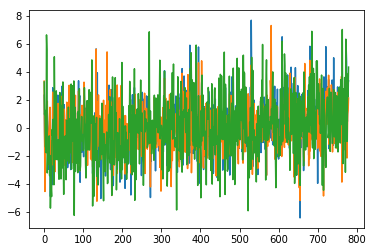

In [12]:
plt.plot(range(X_c.shape[0]), X_c[:,0])
plt.plot(range(X_c.shape[0]), X_c[:,1024])
plt.plot(range(X_c.shape[0]), X_c[:,4096])
plt.show()

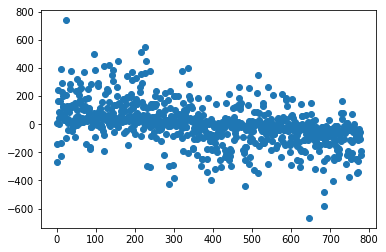

In [13]:
plt.scatter(range(X_c.shape[0]), X_pca[:,0])

In [14]:
X_inv = pca.inverse_transform(X_pca)
print(mean_squared_error(X_c, X_inv))

0.011989413


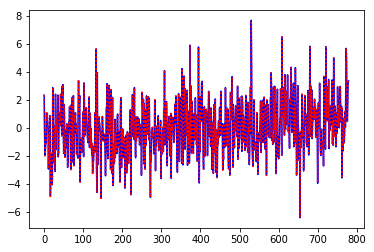

In [29]:
plt.plot(range(X_c.shape[0]), X_c[:,0], c='blue')
plt.plot(range(X_c.shape[0]), X_inv[:,0], ':', c='red')
plt.show()